# The HeatRoadmap Europe project estimated the end use thermal demand in the household, tertiary, and industry sectors for all European countries in the year 2015.
# Here, we examine how direct Eurostat data and our constructed data compares to the HRE project output.

In [1]:
import glob
import sys

import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns 

sys.path.append('../land-eligibility/src/')
from utils import read_config
sys.path.append('../src/construct/')
import util
import annual_heat_demand

config = read_config('../config/default.yaml')

idx = pd.IndexSlice

In [2]:
# Our data
hh_end_use="../data/automatic/hh_end_use.tsv.gz"
ch_end_use="../data/automatic/ch_hh_end_use.xlsx"
countries=config["scope"]["countries"]
heat_tech_params=config["parameters"]["heat-techs"]
energy_balance = '../build/annual_energy_balances.csv'
population = '../land-eligibility/build/national/population.csv'

country_codes = {
    util.get_alpha2(i, eurostat=True): util.get_alpha3(i) for i in countries
}
# Get annual energy balance data for household and commercial sectors
hh_energy_balance_df, cp_energy_balance_df = annual_heat_demand.get_energy_balances(
    energy_balance, country_codes
)
# Get household energy consumption by end use
annual_consumption = annual_heat_demand.get_household_energy_consumption(
    hh_end_use, ch_end_use, country_codes
)

# get commercial energy consumption by end use
annual_consumption = annual_heat_demand.get_commercial_energy_consumption(
    cp_energy_balance_df, ch_end_use, country_codes,
    heat_tech_params, annual_consumption
)
# Fix data gaps for some countries
annual_consumption = annual_heat_demand.hardcoded_country_cleanup(
    annual_consumption, hh_energy_balance_df
)

# convert data units from TJ to TWh
annual_consumption = annual_consumption.apply(util.tj_to_twh)

# We only need the year 2015
annual_consumption = annual_consumption[2015]

# reorder data to match HRE
new_idx = annual_consumption.index.get_level_values('cat_name').map({
    'commercial_space_heating': ('commercial', 'space_heating'), 
    'commercial_water_heating': ('commercial', 'water_heating'), 
    'cooking': ('household', 'cooking'),
    'space_heating': ('household', 'space_heating'), 
    'water_heating': ('household', 'water_heating')
}).rename(['cat_name', 'end_use'])
annual_consumption.index = [annual_consumption.index.get_level_values('country_code'), new_idx.get_level_values(0), new_idx.get_level_values(1), annual_consumption.index.get_level_values('carrier_name')]

/cluster/work/apatt/brynmorp/miniconda/envs/euro-spores/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/cluster/work/apatt/brynmorp/miniconda/envs/euro-spores/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2895: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


In [3]:
# HRE data
HRE_dfs = []
for k, v in {
    'household': dict(sheet_name='Residential data', skiprows=6, index_col=[0, 1], usecols="F,K,V:X"), 
    'commercial': dict(sheet_name='Tertiary data', skiprows=4, index_col=[0, 1], usecols="F,L,O:Q"),
    'industry': dict(sheet_name='Industry data', skiprows=7, index_col=[0, 1], usecols="N,S,X:AB")
}.items():
    _df = pd.read_excel('https://heatroadmap.eu/wp-content/uploads/2018/09/HRE4-Exchange-Template-WP3_v22b_website.xlsx', **v)
    if k == 'household':
        _df.columns = pd.Index(['water_heating', 'space_heating', 'cooking'], name='end_use')  # Assume HRE 'other heating' is just cooking
    elif k == 'commercial':
        _df.columns = pd.Index(['water_heating', 'space_heating', 'process_heating'], name='end_use')
    elif k == 'industry':
        _df = _df.groupby({
            'PH <100 (FED)': 'process_heating',
            'PH 100-200 (FED)': 'process_heating',
            'PH 200-500 (FED)': 'process_heating',
            'PH >500 (FED)': 'process_heating',
            'SH (FED)': 'space_heating'
        }, axis=1).sum().rename_axis(columns='end_use')

    _df.index = (
        _df.index.set_names(['country_code', 'carrier_name'])
    )

    _df = (
        _df
        .apply(util.to_numeric)
        .dropna(how='all')
        .groupby([
            {i: util.get_alpha3(i) for i in _df.index.levels[0]},
            {'Biomass': 'biomass',
            'Coal': 'solid_fossil',
            'Compression cooling (electricity)': 'electricity',
            'District heating': 'heat',
            'Electric Heating': 'electricity',
            'Gas': 'natural_gas',
            'Heat pumps total (electric)': 'electricity',
            'Micro CHP (biomass)': 'biomass',
            'Micro CHP (natural gas)': 'natural_gas',
            'Oil': 'oil',
            'Others (RES)': 'other_renewable',
            'Others (fossil)': 'solid_fossil',  # This is where things like 'peat' and shale sand oil has gone from Eurostat...
            'Solar thermal': 'solar_thermal'},
        ], level=[0, 1]).sum()
        .assign(cat_name=k)
        .set_index('cat_name', append=True)
        .stack()
        .reorder_levels(['country_code', 'cat_name', 'end_use', 'carrier_name'])
    )
    HRE_dfs.append(_df)
HRE_df = pd.concat(HRE_dfs)

In [4]:
HRE_df.to_csv('../data/industry_end_use_2015_FORECAST_HeatRoadmap.csv')

In [11]:
annual_consumption = annual_consumption.unstack([0, 1, 2]).groupby({
    'ambient_heat': 'other_renewable', 
    'biogas': 'biomass', 
    'biomass': 'biomass', 
    'coal': 'solid_fossil', 
    'direct_electric': 'electricity',
    'electricity': 'electricity', 
    'heat': 'heat', 
    'heat_pump': 'electricity', 
    'natural_gas': 'natural_gas', 
    'oil': 'oil',
    'solar_thermal': 'solar_thermal'
}).sum().rename_axis(index='carrier_name').stack([0, 1, 2])

In [14]:
annual_consumption = annual_consumption.reorder_levels(['country_code', 'cat_name', 'end_use', 'carrier_name'])

In [15]:
all_data = pd.concat([annual_consumption, HRE_df], names=['source'], keys=['Eurostat_or_us', 'HRE'])

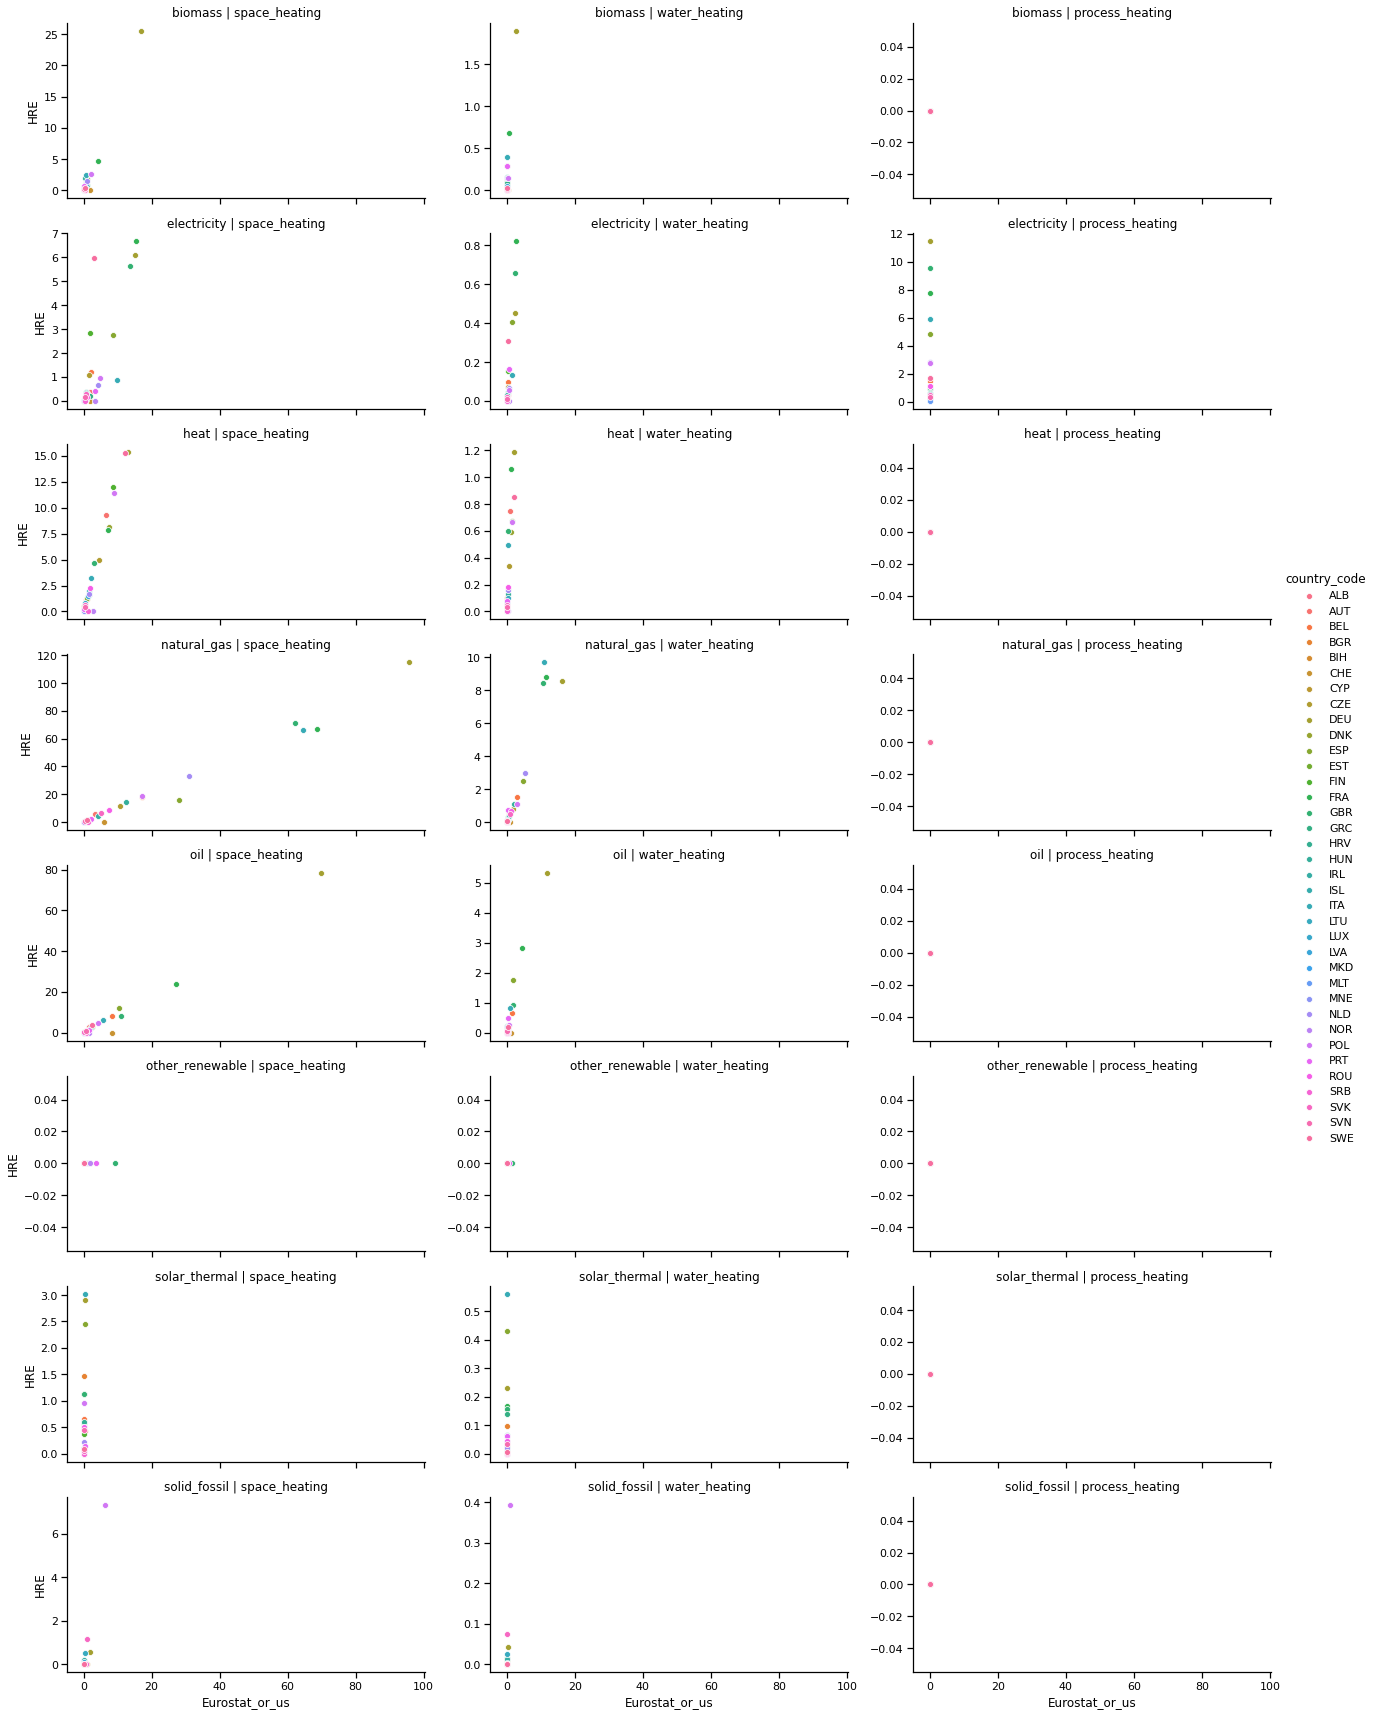

In [17]:
_df = all_data.unstack('source').reset_index().fillna(0)

with sns.plotting_context("notebook", font_scale=1):
    g = sns.FacetGrid(
        _df[_df.cat_name == 'commercial'],
        col="end_use", 
        row="carrier_name",
        hue="country_code",  
        hue_order=_df.country_code.unique(),
        aspect=2, sharey=False
    )
    g.map(
        sns.scatterplot, 'Eurostat_or_us', 'HRE'
    )
    g.add_legend()
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
#foo = [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]



In [22]:
HRE_df.xs(('GBR', 'commercial', 'space_heating'))

carrier_name
biomass             0.826554
electricity         5.638005
heat                4.635046
natural_gas        71.588543
oil                 8.236066
other_renewable     0.000000
solar_thermal       1.132013
solid_fossil        0.170979
dtype: float64

In [28]:
HRE_df.xs(('AUT', 'commercial', 'space_heating')).sum()

20.296696639412495

In [29]:
foo = np.array([
    2.6, 220.1, 0.7, 317.4, 55.7, 7.2, 687.7, 18.0, 18.8
])
util.ktoe_to_twh(1339.6)

15.579547999999999

In [30]:
annual_consumption.xs(('AUT', 'commercial', 'space_heating')).sum()

15.635152235208338